In [1]:
import os
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score

In [2]:
df = pd.read_csv("../input/twitter_sentiment_data.csv")
df.drop(columns=["tweetid"])
df = df.drop(df[df.sentiment == 2].index)

cv_all, test = np.split(df.sample(frac=1, random_state=0), [int(.8*len(df))])
cv_all_polar = cv_all.drop(cv_all[cv_all.sentiment == 0].index)
test_polar = test.drop(test[test.sentiment == 0].index)
print(cv_all.shape)
print(test.shape)

(27733, 3)
(6934, 3)


In [3]:
if not os.path.isfile(f"model/config.json"):
    new_model = SentenceTransformer("all-MiniLM-L12-v2")
    new_model.save("model/")
transformer = SentenceTransformer.load("model/")

In [4]:
def preprocess_dataframe(dataframe):
    messages = dataframe["message"].values
    processed = []
    for message in messages:
        remove_retweets = re.sub(r"RT @\w+:", "", message)
        remove_ats = re.sub(r"@\w+:", "", remove_retweets)
        remove_hashtags = re.sub(r"#", "", remove_ats)
        processed.append(remove_hashtags)
    encoded = transformer.encode(processed)
    dataframe["encoded"] = encoded.tolist()

In [5]:
preprocess_dataframe(cv_all)
preprocess_dataframe(cv_all_polar)

In [6]:
model = svm.SVC(kernel="poly")
# scores = cross_val_score(model, cv_all["encoded"].tolist(), cv_all["sentiment"], cv=5)
# print(scores)

In [7]:
def scores_f1(estimator, X, y):
    y_pred = estimator.predict(X)
    return f1_score(y, y_pred, average='micro')

def scores_accuracy(estimator, X, y):
    y_pred = estimator.predict(X)
    return accuracy_score(y, y_pred)

In [8]:
scores_dict_f1 = cross_val_score(model, cv_all["encoded"].tolist(), cv_all["sentiment"], scoring=scores_f1, cv=5)
print(f"f1 scores with neutral: {scores_dict_f1}")

f1 scores with neutral: [0.78799351 0.79015684 0.78510907 0.79102056 0.79065994]


In [9]:
scores_dict_accuracy = cross_val_score(model, cv_all["encoded"].tolist(), cv_all["sentiment"], scoring=scores_accuracy, cv=5)
print(f"accuracy scores with neutral: {scores_dict_accuracy}")

accuracy scores with neutral: [0.78799351 0.79015684 0.78510907 0.79102056 0.79065994]


In [10]:
#without neutral
model_polar = svm.SVC(kernel="poly")

In [11]:
scores_dict_f1_polar = cross_val_score(model_polar, cv_all_polar["encoded"].tolist(), cv_all_polar["sentiment"], scoring=scores_f1, cv=5)
print(f"f1 scores without neutral: {scores_dict_f1_polar}")

f1 scores without neutral: [0.92090657 0.91304348 0.91857506 0.91533657 0.91325468]


In [12]:
scores_dict_accuracy_polar = cross_val_score(model_polar, cv_all_polar["encoded"].tolist(), cv_all_polar["sentiment"], scoring=scores_accuracy, cv=5)
print(f"accuracy scores without neutral: {scores_dict_accuracy_polar}")

accuracy scores without neutral: [0.92090657 0.91304348 0.91857506 0.91533657 0.91325468]


In [13]:
# examples of failure
model.fit(cv_all["encoded"].tolist(), cv_all["sentiment"])



SVC(kernel='poly')

In [14]:
example_predictions = model.predict(cv_all["encoded"].tolist()[:200])
for i in range(200):
    if example_predictions[i] != cv_all['sentiment'].tolist()[i]:
        print(f"\n prediction:{example_predictions[i]} true:{cv_all['sentiment'].tolist()[i]} \n message:{cv_all['message'].tolist()[i]}")


 prediction:1 true:-1 
 message:RT @TwitchyTeam: New York Times 'slammed' with cancellations as punishment for climate change heresy https://t.co/uritRij1d6

 prediction:1 true:0 
 message:We did it, America. We beat global warming. https://t.co/BbZqC4J6zF

 prediction:1 true:-1 
 message:RT @Cernovich: $q$Global warming is real.$q$ - Science https://t.co/BqV5SCZMfq

 prediction:0 true:1 
 message:RT @TheMisterFavor: #NationalGeographicÃ¢â‚¬â„¢s climate change documentary with #LeonardoDiCaprio is now on #YouTube! https://t.co/yEA6kinX2AÃ¢â‚¬Â¦

 prediction:1 true:-1 
 message:RT @matthaggis666: Today on #abcforkids we have IPA's Georgina Downer explaining why climate change isn't real, and how voluntary voting isÃ¢â‚¬Â¦

 prediction:0 true:-1 
 message:Rebel Media: So who are the scientists who$q$ll be advising Trudeau, premiers on climate change?… https://t.co/Eioh8m817F #tcot #tlot #tgdn

 prediction:1 true:0 
 message:When Mother Earth sees you tweet that climate change isnâ€™t re

In [15]:

#reddit data (copied from Thierry's section)
reddit_df = pd.read_csv('../input/reddit_opinion_climate_change.csv',index_col=['comment_id'], parse_dates=['created_time', 'post_created_time'])
filtered_reddit_df = reddit_df.loc[reddit_df['subreddit'].isin(['climatechange', 'climate', 'climateskeptics'])]



In [32]:
def preprocess_dataframe_reddit(dataframe):
    messages = dataframe["self_text"].values
    processed = []
    for message in messages:
        as_str = str(message) if message is not None else ''
        remove_retweets = re.sub(r"RT @\w+:", "", as_str)
        remove_ats = re.sub(r"@\w+:", "", remove_retweets)
        remove_hashtags = re.sub(r"#", "", remove_ats)
        processed.append(remove_hashtags)
    encoded = transformer.encode(processed)
    dataframe["encoded"] = encoded.tolist()
    
    dataframe['month'] = pd.DatetimeIndex(dataframe['post_created_time']).month
    dataframe['year'] = pd.DatetimeIndex(dataframe['post_created_time']).year

In [49]:
sampled_reddit_df = filtered_reddit_df.sample(n=50000, random_state=0)
preprocess_dataframe_reddit(sampled_reddit_df)

In [48]:
sampled_reddit_df["predictions"] = model.predict(sampled_reddit_df["encoded"].tolist())

/var/folders/sm/4_mv26151mn1lbt6brxchmtc0000gp/T/ipykernel_87224/1705668610.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_reddit_df["predictions"] = model.predict(sampled_reddit_df["encoded"].tolist())


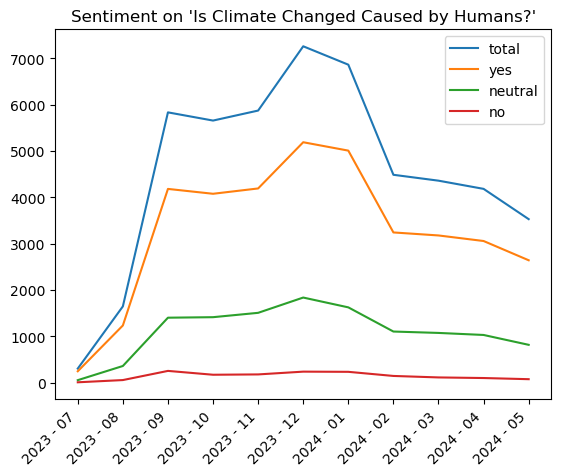

In [59]:
plot_pos_time = dict()
plot_neg_time = dict()
plot_zero_time = dict()
plot_time = dict()

plot_pos_sub = dict()
plot_neg_sub = dict()
plot_zero_sub = dict()
plot_sub = dict()

def time(entry):
    if entry['month'] < 10:
        return f"{entry['year']} - 0{entry['month']}"
    else:
        return f"{entry['year']} - {entry['month']}"

for index, entry in sampled_reddit_df.iterrows():
    if time(entry) not in plot_pos_time:
        plot_pos_time[time(entry)] = 0 
    if time(entry) not in plot_neg_time:
        plot_neg_time[time(entry)] = 0      
    if time(entry) not in plot_zero_time:
        plot_zero_time[time(entry)] = 0
    if time(entry) not in plot_time:
        plot_time[time(entry)] = 0
        
    if entry["subreddit"] not in plot_pos_sub:
        plot_pos_sub[entry["subreddit"]] = 0
    if entry["subreddit"] not in plot_neg_sub:
        plot_neg_sub[entry["subreddit"]] = 0 
    if entry["subreddit"] not in plot_zero_sub:
        plot_zero_sub[entry["subreddit"]] = 0 
    if entry["subreddit"] not in plot_sub:
        plot_sub[entry["subreddit"]] = 0 
    
        
    plot_time[time(entry)] += 1
    plot_sub[entry["subreddit"]] += 1 
    if entry["predictions"] == 1:
        plot_pos_time[time(entry)] += 1
        plot_pos_sub[entry['subreddit']] += 1
    elif entry['predictions'] == -1:
        plot_neg_time[time(entry)] += 1
        plot_neg_sub[entry["subreddit"]] += 1
    elif entry["predictions"] == 0:
        plot_zero_time[time(entry)] += 1
        plot_zero_sub[entry["subreddit"]] += 1

plt.title("Sentiment on \'Is Climate Changed Caused by Humans?\' in Selected Subreddits")
plt.xticks(rotation=45, ha='right')


lists = sorted(plot_time.items())
x, y = zip(*lists)
plt.plot(x, y, label = "total")

lists = sorted(plot_pos_time.items())
x, y = zip(*lists)
plt.plot(x, y, label = "yes")

lists = sorted(plot_zero_time.items())
x, y = zip(*lists)
plt.plot(x, y, label = "neutral")

lists = sorted(plot_neg_time.items())
x, y = zip(*lists)
plt.plot(x, y, label = "no")

plt.legend() 
plt.show()

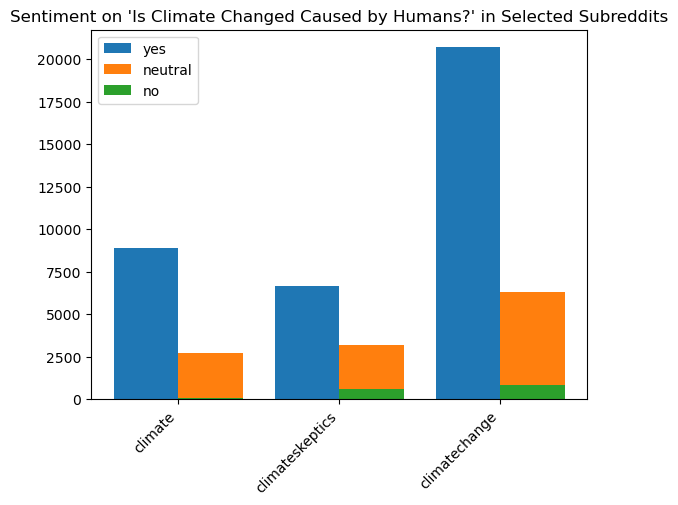

In [62]:
plt.title("Sentiment on \'Is Climate Changed Caused by Humans?\' in Selected Subreddits")
plt.xticks(rotation=45, ha='right')

subreddits = ['climate', 'climateskeptics', 'climatechange']
pos = [plot_pos_sub[sr] for sr in subreddits]
zero = [plot_zero_sub[sr] for sr in subreddits]
neg = [plot_neg_sub[sr] for sr in subreddits]

X_axis = np.arange(len(subreddits)) 
  
plt.bar(X_axis - 0.2, pos, 0.4, label = 'yes') 
plt.bar(X_axis + 0.2, zero, 0.4, label = 'neutral') 
plt.bar(X_axis + 0.2, neg, 0.4, label = 'no') 



plt.xticks(X_axis, subreddits) 
plt.legend() 
plt.show()

In [20]:
# use test data